In [2]:
import pandas as pd

In [2]:
data = pd.read_csv('../01_data/03_final/emission.csv')
data = data.loc[(data['CO2_Emission'] > 0)]
data = data.loc[~(data['Year'] > 2015)]
data = data.loc[~(data['Year'] < 1998)]
data

,ORSPL,PLANT_NAME,rggi,Low_Income,PRIME_MOVER,UNIT_SIZE,FUEL_TYPE,Year,CO2_Emission,Post
1914,544,Devon Station,1,0,GT,>=25,Oil,1998,37959.550,0
1915,544,Devon Station,1,0,ST,>=25,Oil,1998,1103878.626,0
1919,546,Montville Station,1,0,ST,>=25,Oil,1998,1380947.100,0
1922,548,NRG Norwalk Harbor,1,0,ST,>=25,Oil,1998,1707288.125,0
1927,562,Middletown,1,0,ST,>=25,Natural Gas,1998,2456580.400,0
...,...,...,...,...,...,...,...,...,...,...
92436,58001,Panda Temple Power Station,0,1,CC,>=25,Natural Gas,2015,2905832.601,1
92437,58005,Panda Sherman Power Station,0,0,CC,>=25,Natural Gas,2015,1445300.240,1
92491,58325,Charles D. Lamb Energy Center,0,0,GT,>=25,Natural Gas,2015,26067.588,1
92503,58427,Lansing BWL REO Town Plant,0,1,CC,>=25,Natural Gas,2015,243136.758,1


In [7]:
pre_2005_filtered = data[(data['Year'] < 2005)]
post_2008_filtered = data[(data['Year'] > 2008)]

# Further filtering the data into low income and not low income groups for the analysis
pre_2005_low_income = pre_2005_filtered.groupby(['rggi', 'Low_Income']).CO2_Emission.mean()
post_2008_low_income = post_2008_filtered.groupby(['rggi', 'Low_Income']).CO2_Emission.mean()

# Calculate the changes in CO2 emissions for treated and control groups within low income and not low income
changes = post_2008_low_income - pre_2005_low_income

# Calculate the Difference-in-Differences estimator for each low income status
did_estimators = {}
for low_income in [0, 1]:
    control_change = changes[(0, low_income)]
    treated_change = changes[(1, low_income)]
    did_estimators[low_income] = treated_change - control_change

# Organize the results into a DataFrame
results = pd.DataFrame({
    'Pre-Treatment Mean Emissions': pre_2005_low_income,
    'Post-Treatment Mean Emissions': post_2008_low_income,
    'Change in Emissions': changes
})

did_income = {}
for rggi in [0, 1]:
    change_non_low_income = changes[(rggi, 0)]
    change_low_income = changes[(rggi, 1)]
    did_income[rggi] = change_low_income - change_non_low_income

# Calculate the difference between DiD estimates of RGGI = 1 and RGGI = 0 for different income levels
diff_did = did_estimators[1] - did_estimators[0]

# Adding these calculations to the results DataFrame
results['DiD Between Income Groups'] = [did_income[rggi] if li == 1 else None for rggi, li in results.index]
results['Diff DiD RGGI 1 vs RGGI 0'] = [diff_did if (rggi, li) == (1, 1) else None for rggi, li in results.index]

results

Pre-Treatment Mean Emissions  Post-Treatment Mean Emissions  \
rggi Low_Income                                                                
0    0                           2.910472e+06                   2.038595e+06   
     1                           2.334942e+06                   1.610195e+06   
1    0                           1.050366e+06                   3.228510e+05   
     1                           9.440914e+05                   3.969837e+05   

                 Change in Emissions  DiD Between Income Groups  \
rggi Low_Income                                                   
0    0                -871877.399924                        NaN   
     1                -724747.055469              147130.344455   
1    0                -727515.501519                        NaN   
     1                -547107.709702              180407.791818   

                 Diff DiD RGGI 1 vs RGGI 0  
rggi Low_Income                             
0    0                                 NaN  
     1                                 NaN  
1    0                                 NaN  
     1                        33277.447362

In [10]:
import statsmodels.api as sm
# Create the necessary interaction terms for the full dataset analysis
data['rggi_low_income'] = data['rggi'] * data['Low_Income']
data['post_low_income'] = data['Post'] * data['Low_Income']
data['post_treatment'] = data['Post'] * data['rggi']
data['post_treatment_low_income'] = data['post_treatment'] * data['Low_Income']

# Setting up the regression model with interaction terms to quantify the difference between DiD estimates
X_full = data[['rggi', 'Low_Income', 'Post', 'post_treatment', 'rggi_low_income', 'post_low_income', 'post_treatment_low_income']]
X_full = sm.add_constant(X_full)  # adding a constant
y_full = data['CO2_Emission']

# Fit the model
model_full = sm.OLS(y_full, X_full).fit()

# Getting the summary of the model
model_full_summary = model_full.summary()
model_full_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CO2_Emission   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     144.1
Date:                Wed, 01 May 2024   Prob (F-statistic):          6.59e-208
Time:                        00:12:01   Log-Likelihood:            -3.0709e+05
No. Observations:               18692   AIC:                         6.142e+05
Df Residuals:                   18684   BIC:                         6.143e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2.673e+06   4.79e+04     55.831      0.000    2.58e+06    2.77e+06
rggi                       -1.73e+06   1.13e+05    -15.366      0.000   -1.95e+06   -1.51e+06
Low_Income                -5.257e+05   7.41e+04     -7.095      0.000   -6.71e+05    -3.8e+05
Post                      -6.342e+05   7.21e+04     -8.796      0.000   -7.75e+05   -4.93e+05
post_treatment             1.398e+04   1.45e+05      0.096      0.923   -2.71e+05    2.99e+05
rggi_low_income            3.937e+05   1.93e+05      2.043      0.041     1.6e+04    7.71e+05
post_low_income            9.729e+04   1.12e+05      0.871      0.384   -1.22e+05    3.16e+05
post_treatment_low_income  1.088e+05   2.63e+05      0.415      0.678   -4.06e+05    6.23e+05
==============================================================================
Omnibus:                    11108.092   Durbin-Watson:                   1.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            95522.903
Skew:                           2.824   Prob(JB):                         0.00
Kurtosis:                      12.526   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

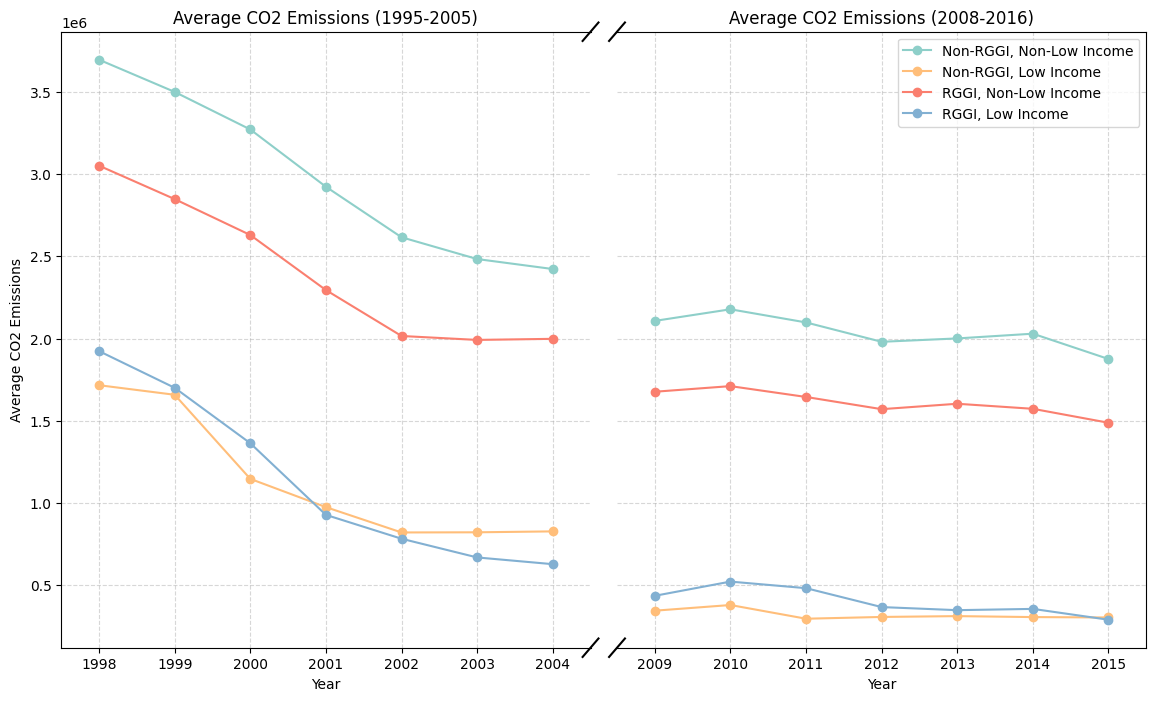

In [16]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 8))
fig.subplots_adjust(wspace=0.05)  # Adjust space between the plots

grouped_data = data.groupby(['Year', 'rggi', 'Low_Income']).CO2_Emission.mean().unstack().unstack()
custom_positions_pre = [year for year in grouped_data.index if year < 2005]
custom_positions_post = [year for year in grouped_data.index if year > 2008]

colors = ['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2']
labels = [
    'Non-RGGI, Non-Low Income',
    'Non-RGGI, Low Income',
    'RGGI, Non-Low Income',
    'RGGI, Low Income'
]

# Plotting for each combination of RGGI and Low Income status with a broken axis
for i, (rggi, low_income) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    ax1.plot(custom_positions_pre, grouped_data.loc[custom_positions_pre, (rggi, low_income)], label=labels[i], color=colors[i], marker='o')
    ax2.plot(custom_positions_post, grouped_data.loc[custom_positions_post, (rggi, low_income)], label=labels[i], color=colors[i], marker='o')  # Ensure labels are assigned here as well

# Set the limits for the x-axis to create a broken axis effect
ax1.set_xlim(min(custom_positions_pre)-0.5, 2004.5)  # data up to 2005
ax2.set_xlim(2008.5, max(custom_positions_post)+0.5)  # data from 2008 onwards

# Hide the spines between ax1 and ax2
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)

# Hide the y-ticks on the second subplot
ax2.tick_params(axis='y', which='both', length=0)

# Add grid lines
ax1.grid(True, linestyle='--', alpha=0.5)
ax2.grid(True, linestyle='--', alpha=0.5)

# Create the 'break' marks on the axes
d = .015  # length of diagonal lines at breaks
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

# Adding legends and titles
ax2.legend(loc='upper right')
ax1.set_title('Average CO2 Emissions (1995-2005)')
ax2.set_title('Average CO2 Emissions (2008-2016)')
ax1.set_xlabel('Year')
ax2.set_xlabel('Year')
ax1.set_ylabel('Average CO2 Emissions')

plt.show()

In [43]:
data = pd.read_csv('../01_data/03_final/type.csv')

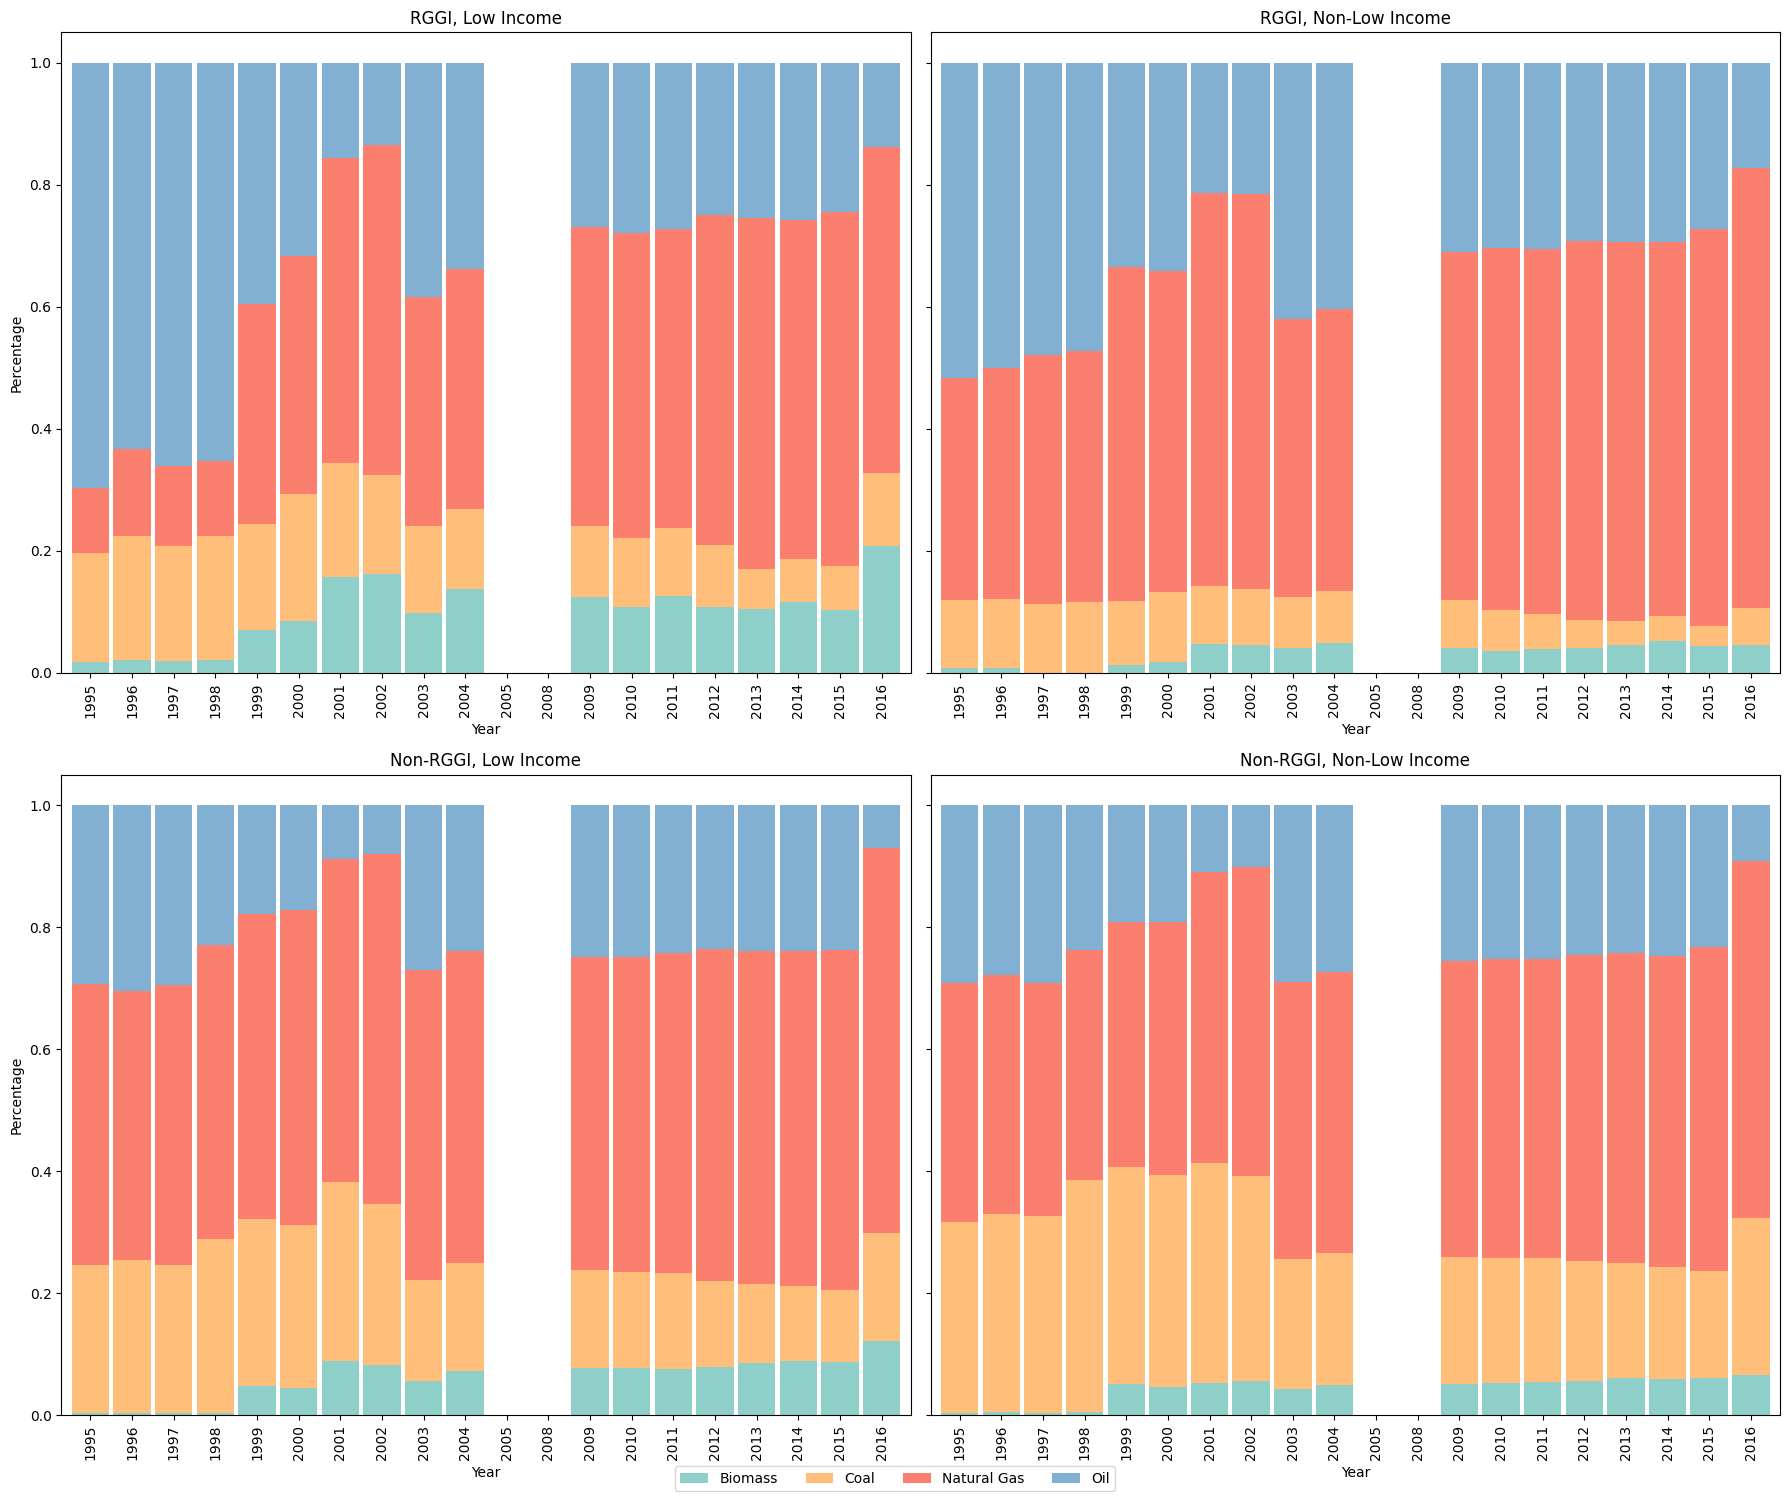

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

filtered_data = data[~data['Year'].isin([2006, 2007])]

# Group and summarize the data
grouped_data = filtered_data.groupby(['Year', 'rggi', 'Low_Income', 'fuel']).size().reset_index(name='Count')

# Pivot the data to get years on the index and fuel types as columns, filling missing values with 0
pivot_data = grouped_data.pivot_table(index=['Year', 'rggi', 'Low_Income'], 
                                      columns='fuel', 
                                      values='Count', 
                                      aggfunc='sum', 
                                      fill_value=0)

# Normalize the data by row to convert counts to percentages
pivot_data = pivot_data.div(pivot_data.sum(axis=1), axis=0)

# Explicitly setting years 2005 to 2008 values to zero
for year in [2005, 2008]:
    if year in pivot_data.index.get_level_values('Year'):
        pivot_data.loc[(year, slice(None), slice(None)), :] = 0

#set up
colors = ['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2']
all_years = np.arange(filtered_data['Year'].min(), filtered_data['Year'].max() + 1)
# Plotting

fig, axes = plt.subplots(2, 2, figsize=(18, 15), sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

plot_titles = {
    (1, 1): 'RGGI, Low Income',
    (1, 0): 'RGGI, Non-Low Income',
    (0, 1): 'Non-RGGI, Low Income',
    (0, 0): 'Non-RGGI, Non-Low Income'
}
# Generate plots for each combination of RGGI and Low Income status
for i, ((rggi, low_income), ax) in enumerate(zip(plot_titles.keys(), axes)):
    # Select the appropriate subset of data
    subset = pivot_data.xs((rggi, low_income), level=('rggi', 'Low_Income'))
    
    # Plot as a stacked bar chart using the specified colors
    subset.plot(kind='bar', stacked=True, ax=ax, legend=0, color=colors, width=0.9)
    ax.set_title(plot_titles[(rggi, low_income)])
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Year')

# Adjust legend to be horizontal and at the bottom
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels))
plt.tight_layout()
plt.show()

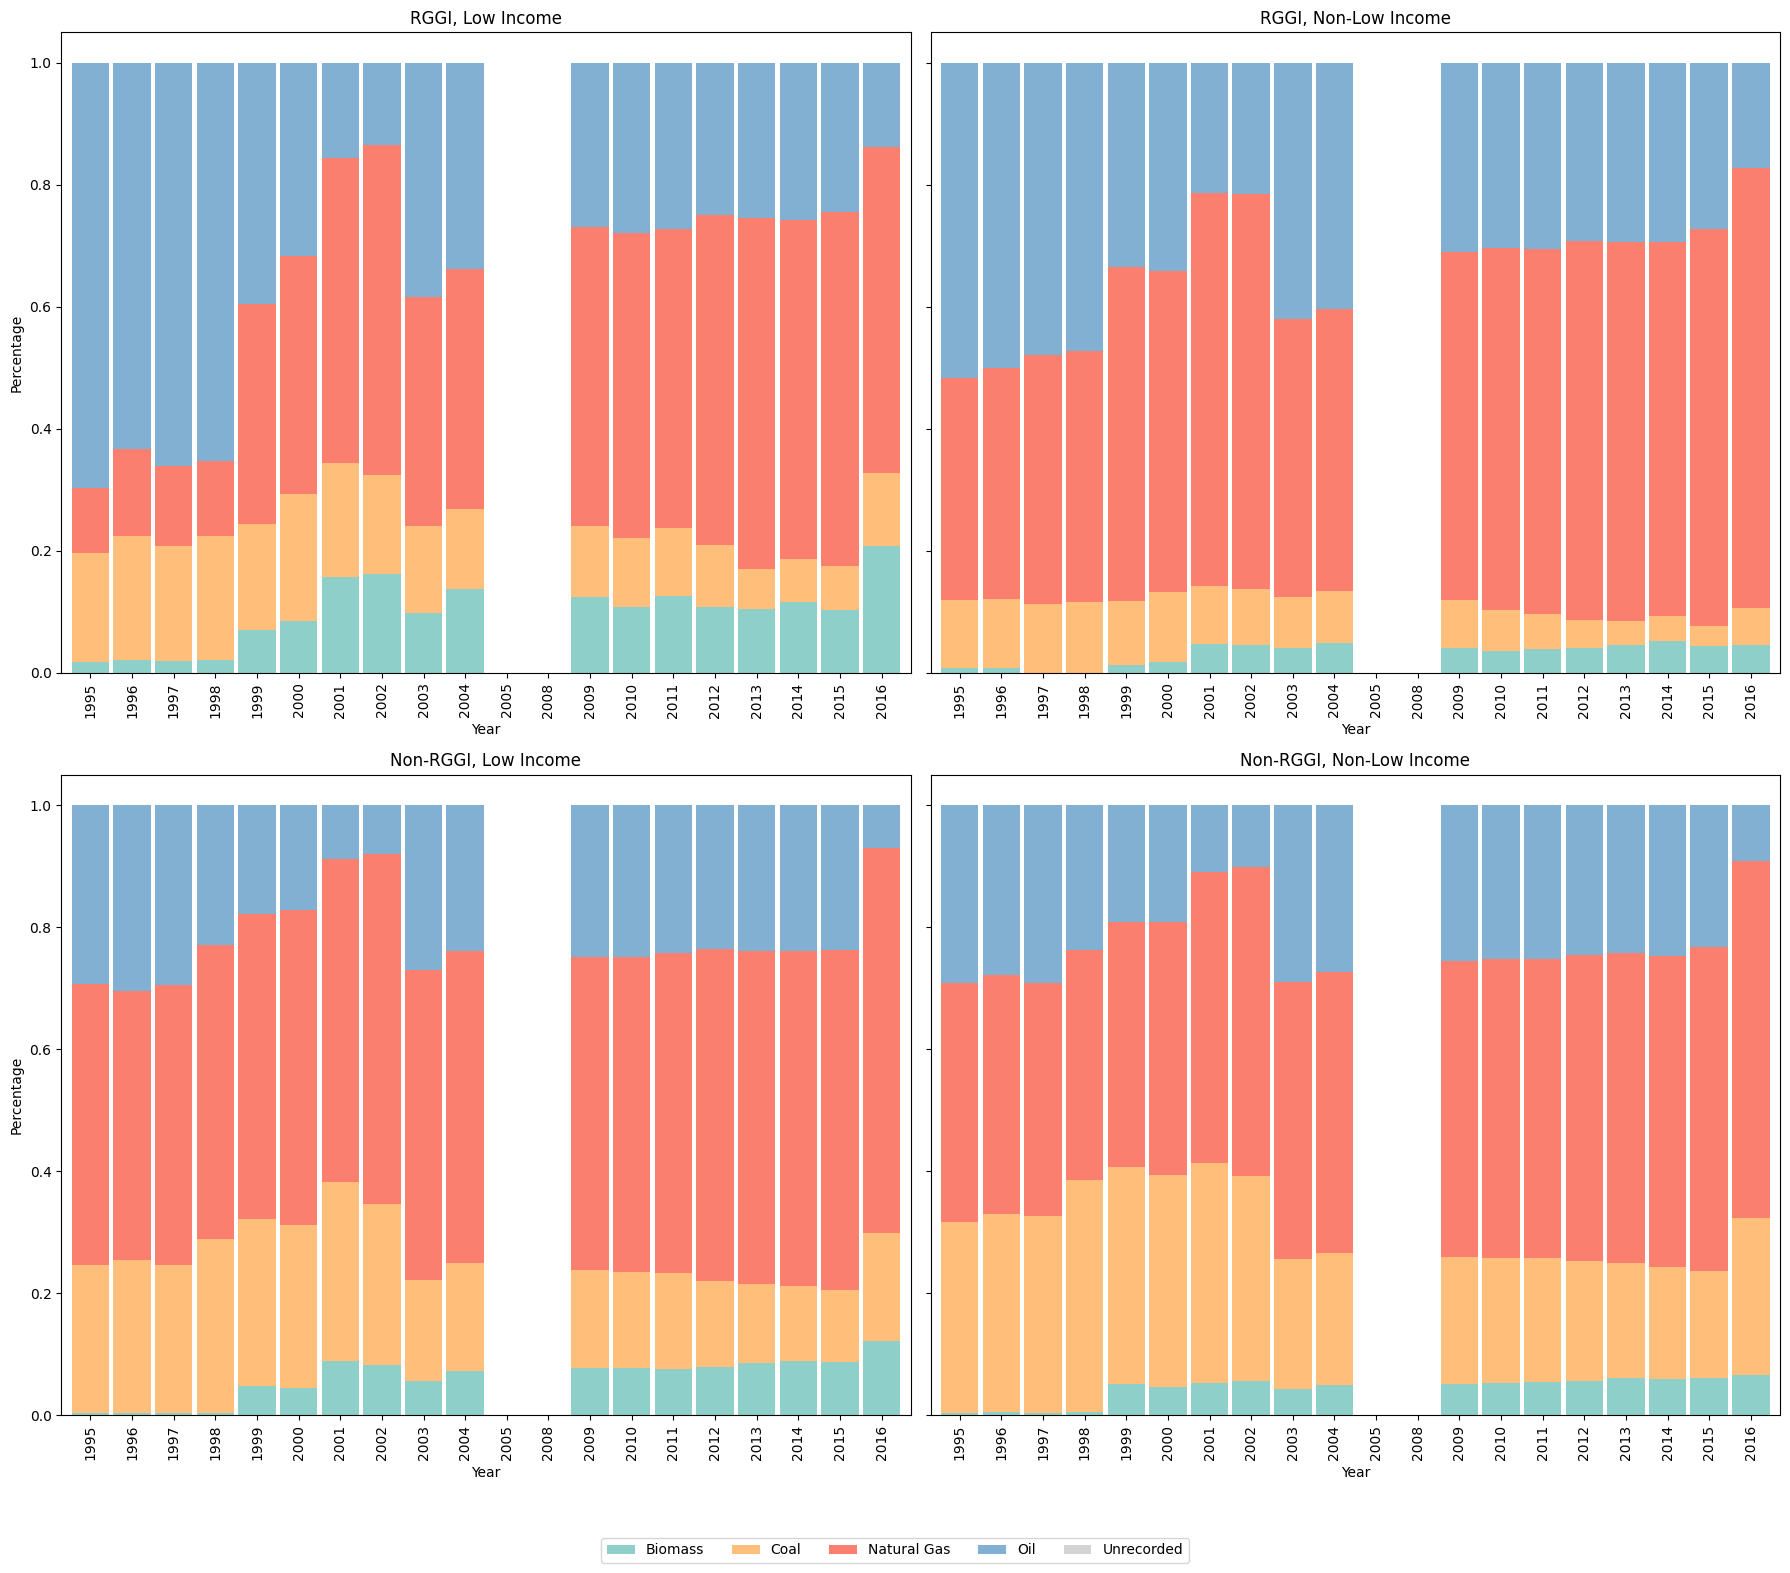

In [49]:
filtered_data = data[~data['Year'].isin([2006, 2007])]

# Define all expected fuel categories
expected_fuels = ['Coal', 'Oil', 'Natural Gas', 'Biomass', 'Unrecorded']  # Add 'Unrecorded' or other missing categories as needed

# Group and summarize the data
grouped_data = filtered_data.groupby(['Year', 'rggi', 'Low_Income', 'fuel']).size().reset_index(name='Count')

# Ensure all fuel types are represented in the dataset
for fuel in expected_fuels:
    if fuel not in grouped_data['fuel'].unique():
        extra_row = pd.DataFrame([[year, rggi, low_income, fuel, 0] for year in filtered_data['Year'].unique() for rggi in [0, 1] for low_income in [0, 1]],
                                 columns=['Year', 'rggi', 'Low_Income', 'fuel', 'Count'])
        grouped_data = pd.concat([grouped_data, extra_row], ignore_index=True)

# Pivot the data to get years on the index and fuel types as columns, filling missing values with 0
pivot_data = grouped_data.pivot_table(index=['Year', 'rggi', 'Low_Income'], 
                                      columns='fuel', 
                                      values='Count', 
                                      aggfunc='sum', 
                                      fill_value=0)

# Normalize the data by row to convert counts to percentages
pivot_data = pivot_data.div(pivot_data.sum(axis=1), axis=0)

# Explicitly setting years 2005 to 2008 values to zero
for year in [2005, 2008]:
    if year in pivot_data.index.get_level_values('Year'):
        pivot_data.loc[(year, slice(None), slice(None)), :] = 0

# Set up colors for the plot
colors = ['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2','lightgray']

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(18, 15), sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

plot_titles = {
    (1, 1): 'RGGI, Low Income',
    (1, 0): 'RGGI, Non-Low Income',
    (0, 1): 'Non-RGGI, Low Income',
    (0, 0): 'Non-RGGI, Non-Low Income'
}

# Generate plots for each combination of RGGI and Low Income status
for i, ((rggi, low_income), ax) in enumerate(zip(plot_titles.keys(), axes)):
    # Select the appropriate subset of data
    subset = pivot_data.xs((rggi, low_income), level=('rggi', 'Low_Income'))
    
    # Plot as a stacked bar chart using the specified colors
    subset.plot(kind='bar', stacked=True, ax=ax, legend=0, color=colors, width=0.9)
    ax.set_title(plot_titles[(rggi, low_income)])
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Year')

# Adjust legend to be horizontal and at the bottom
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.show()

In [22]:
print(grouped_data.isna().sum())
print((grouped_data == float('inf')).sum())
print((grouped_data == float('-inf')).sum())

rggi          0
Low_Income    0
fuel          0
Post          0
Count         0
dtype: int64
rggi          0
Low_Income    0
fuel          0
Post          0
Count         0
dtype: int64
rggi          0
Low_Income    0
fuel          0
Post          0
Count         0
dtype: int64


In [37]:
48210-21591

26619

In [39]:
data

,ORSPL,PLANT_NAME,rggi,Low_Income,PRIME_MOVER,Year,fuel,Post
1,3,Barry,0,0,ST,1995,Coal,0
2,7,Gadsden,0,1,ST,1995,Coal,0
3,8,Gorgas,0,1,ST,1995,Coal,0
4,9,Copper,0,1,GT,1995,Natural Gas,0
7,10,Greene County,0,1,ST,1995,Coal,0
...,...,...,...,...,...,...,...,...
94712,58108,International Paper Red River Mill,0,1,ST,2016,Biomass,1
94713,58109,Georgia-Pacific Toledo Mill,0,1,ST,2016,Biomass,1
94782,58420,Panda Liberty Generation Plant,0,0,CC,2016,Natural Gas,1
94794,58471,Ector County Energy Center,0,1,GT,2016,Natural Gas,1


In [42]:
data.loc[(data['rggi'] ==1) & (data['Low_Income'] ==0)]

,ORSPL,PLANT_NAME,rggi,Low_Income,PRIME_MOVER,Year,fuel,Post
234,542,Cos Cob,1,0,GT,1995,Oil,0
235,542,Cos Cob,1,0,GT,1995,Oil,0
236,544,Devon Station,1,0,GT,1995,Oil,0
237,544,Devon Station,1,0,GT,1995,Oil,0
238,544,Devon Station,1,0,ST,1995,Natural Gas,0
...,...,...,...,...,...,...,...,...
94118,55212,ANP Blackstone Energy Project,1,0,CC,2016,Natural Gas,1
94204,55405,Athens Generating Plant,1,0,CC,2016,Natural Gas,1
94402,56234,Caithness Long Island Energy Center,1,0,CC,2016,Natural Gas,1
94546,56963,West Deptford Energy Station,1,0,CC,2016,Natural Gas,1


In [30]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Create the 'Post' column based on 'Year'
data['Post'] = (data['Year'] > 2008).astype(int)

# Group data by 'rggi', 'Low_Income', 'fuel', and 'Post', count the number of occurrences
grouped_data = data.groupby(['rggi', 'Low_Income', 'fuel', 'Post']).size().reset_index(name='Count')

# Ensure that each group has more than one data point
print("Group sizes:\n", grouped_data.groupby(['rggi', 'Low_Income', 'fuel', 'Post']).size())

# Run ANOVA if there are suitable data points
if not grouped_data.empty and all(grouped_data['Count'] > 1):
    model = ols('Count ~ C(rggi) * C(Low_Income) * C(fuel) * C(Post)', data=grouped_data).fit()
    anova_results = sm.stats.anova_lm(model, typ=2)  # Using Type II sum of squares
    print(anova_results)
else:
    print("Insufficient data for ANOVA.")

Group sizes:
 rggi  Low_Income  fuel         Post
0     0           Biomass      0       1
                               1       1
                  Coal         0       1
                               1       1
                  Natural Gas  0       1
                               1       1
                  Oil          0       1
                               1       1
      1           Biomass      0       1
                               1       1
                  Coal         0       1
                               1       1
                  Natural Gas  0       1
                               1       1
                  Oil          0       1
                               1       1
1     0           Biomass      0       1
                               1       1
                  Coal         0       1
                               1       1
                  Natural Gas  0       1
                               1       1
                  Oil          0       1
       

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1718: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


ValueError: array must not contain infs or NaNs

In [31]:
anova_results

NameError: name 'anova_results' is not defined

In [100]:
pivot_table = grouped_data.pivot_table(index=['rggi', 'Low_Income', 'fuel'], columns='Post', values='Count', aggfunc='sum')
pivot_table.columns = ['before','after']

In [107]:
pivot_table['change'] = pivot_table['after'] - pivot_table['before']

In [114]:
pivot_table

before  after  change
rggi Low_Income fuel                              
0    0          Biomass         492    552      60
                Coal           3251   1922   -1329
                Natural Gas    5554   4899    -655
                Oil            3104   2291    -813
     1          Biomass         585    711     126
                Coal           2146   1217    -929
                Natural Gas    5416   4600    -816
                Oil            2540   1977    -563
1    0          Biomass          85     85       0
                Coal            241    104    -137
                Natural Gas    1273   1237     -36
                Oil             954    575    -379
     1          Biomass         135    128      -7
                Coal            196    102     -94
                Natural Gas     482    582     100
                Oil             497    277    -220